## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Camera calibration

Function `calibrate_camera()` returns `mtx` and `dist` for undistorting images. The chessboard images with corners are saved in `output_images/camera_calibration` folder

In [1]:
import numpy as np
import cv2
import glob
import math
import matplotlib.pyplot as plt
%matplotlib inline

def calibrate_camera():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    output_images_folder = '../output_images/camera_calibration/'

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
            # Save to folder
            output_fname = output_images_folder + fname.split('/')[-1]
            cv2.imwrite(output_fname, img)

    # It is found the grayscale calibration images are all of (720, 1280)
    gray_shape = (720, 1280)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_shape[::-1], None, None)
    return mtx, dist

mtx, dist = calibrate_camera()

## Undistort test images

Function `undistort()` receives an image, `mtx` and `dist`. Images in the `test_images` folder are all undistorted and saved in `output_images/undistort_images` folder

In [2]:
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [3]:
# Make a list of calibration images
images = glob.glob('../test_images/*.jpg')
output_images_folder = '../output_images/undistort_images/'
for fname in images:
    img = cv2.imread(fname)
    dst = undistort(img, mtx, dist)
    # Save to folder
    output_fname = output_images_folder + fname.split('/')[-1]
    cv2.imwrite(output_fname, dst)

## Threshold binary image

Use color transform, different gradient techniques to generate a binary image.
_Note: use `plt.imread()` to load images_

(720, 1280, 3)


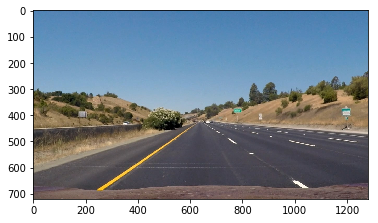

In [4]:
# Load a test image
img = plt.imread('../test_images/straight_lines1.jpg')
print(img.shape)
plt.imshow(img)

In [5]:
# Helper functions
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2, fit=False, trapezoid_height=216, abs_slope=0.5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    # keep original draw_lines for drawing region of interest
    if not fit:
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    else:
        img_shape = img.shape
        left = np.zeros(shape=(0,2), dtype=np.int32)
        right = np.zeros(shape=(0,2), dtype=np.int32)
        for line in lines:
            for x1,y1,x2,y2 in line:
                # by heuristic, lane lanes should have more or less vertial slope
                if ((y2-y1)/(x2-x1))<-abs_slope:
                    left = np.concatenate((line.reshape(2,2), left), axis=0)
                elif ((y2-y1)/(x2-x1))>abs_slope:
                    right = np.concatenate((line.reshape(2,2), right), axis=0)
        # video detection might be flickery, sancity check before fitting the line
        if left.size != 0:
            left_coef_k, left_coef_b = np.polyfit(left[:,0], left[:,1],1)
            cv2.line(img, 
                    (int((img_shape[0]-trapezoid_height-left_coef_b)/left_coef_k), int(img_shape[0]-trapezoid_height)),
                    (int((img_shape[0]-left_coef_b)/left_coef_k), img_shape[0]),
                    color, thickness)
        if right.size != 0:
            right_coef_k, right_coef_b = np.polyfit(right[:,0], right[:,1],1)
            cv2.line(img, 
                    (int((img_shape[0]-trapezoid_height-right_coef_b)/right_coef_k), int(img_shape[0]-trapezoid_height)),
                    (int((img_shape[0]-right_coef_b)/right_coef_k), img_shape[0]),
                    color, thickness)

In [6]:
def sobel_x_or_y_mag_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
    Threshold on either `x` or `y` direction gradient and return a binary output
    `img` could be either color or grayscale image
    """
    min_thresh, max_thresh = thresh
    gray = np.copy(img)
    if len(gray.shape) > 2:
        gray = cv2.cvtColor(gray, cv2.COLOR_RGB2GRAY)
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y', ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= min_thresh) & (scaled_sobel <= max_thresh)] = 1
    return binary_output

def sobel_total_mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    """
    Threshold on the total gradient magnitude and return a binary output
    `img` could be either color or grayscale image
    """
    min_thresh, max_thresh = thresh
    gray = np.copy(img)
    if len(gray.shape) > 2:
        gray = cv2.cvtColor(gray, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel = np.sqrt(sobel_x**2, sobel_y**2)
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= min_thresh) & (scaled_sobel <= max_thresh)] = 1
    return binary_output

def sobel_orientation_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Threshold on the direction of gradient directiona and return a binary output
    `img` could be either color or grayscale image
    """
    min_thresh, max_thresh = thresh
    gray = np.copy(img)
    if len(gray.shape) > 2:
        gray = cv2.cvtColor(gray, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel_dir = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    binary_output = np.zeros_like(sobel_dir)
    binary_output[(sobel_dir >= min_thresh) & (sobel_dir <= max_thresh)] = 1
    return binary_output

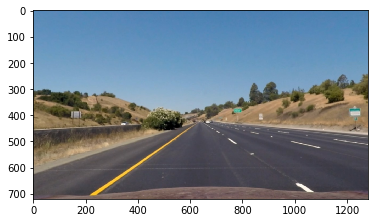

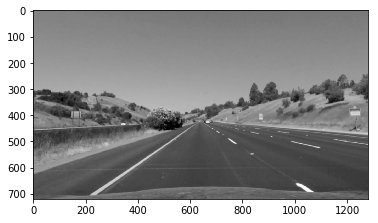

In [8]:
def prepross_img(img):
    gaussian_kernal_size = 5
    undistorted = undistort(img, mtx, dist)
    blurred = gaussian_blur(undistorted, gaussian_kernal_size)
    return blurred
blurred = prepross_img(img)
gray = grayscale(blurred)

plt.figure()
plt.imshow(blurred)
plt.figure()
plt.imshow(gray, cmap='gray')

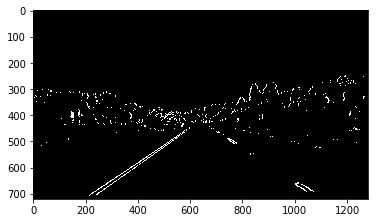

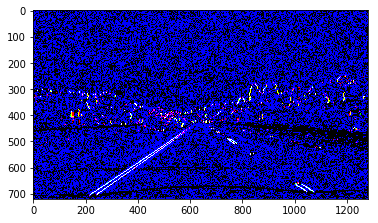

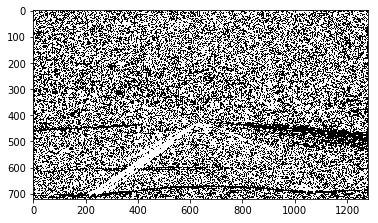

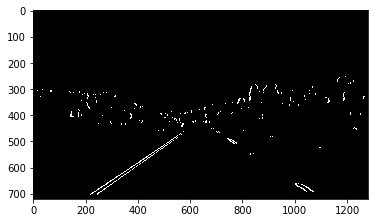

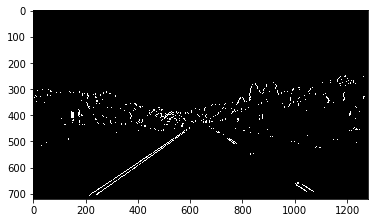

In [9]:
# Building pipeline
# Only threshold upon x direction gradient maginitude because lane lines are mostly vertical.
# Threshold on y direction gradient could give lane line shape, but it also introduces fair amount of
# noises.
# Only threshold the lower bound, becase I want to limit the potential big gradient around lane lines
# However, lower thershold should filter out surroundings, like forests.
sobel_x_kernel_size = 3
sobel_x_thresh = (50, 255)
sobel_x = sobel_x_or_y_mag_thresh(gray, 'x', sobel_x_kernel_size, sobel_x_thresh)

# Keep the threshold the same as above but increase the kernel size to smooth result.
sobel_totoal_kernel_size = 15
sobel_total_thresh = (80, 255)
sobel_total = sobel_total_mag_thresh(gray, sobel_totoal_kernel_size, sobel_total_thresh)

# From here we could potentially use Hough transform, however it is limited to staright lines only, and we want to 
# fit a second order lane curve.

# Vertical lines have orientation of 0, 0degree, horizontal lines have orientation of pi/2=1.57=90 degree. Lane lines should be around 
# 20 degree to 75 degree
sobel_dir_kernal_size = 11
sobel_dir_thresh = (0.35, 1.3)
sobel_dir = sobel_orientation_thresh(gray, sobel_dir_kernal_size, sobel_dir_thresh)

sobel_stack = np.uint8(np.dstack((sobel_x,sobel_total,sobel_dir))*255)

sobel_combined = np.zeros_like(sobel_dir)
sobel_combined[(sobel_x == 1) | ((sobel_total == 1) & (sobel_dir == 1))] = 1

plt.figure()
plt.imshow(sobel_combined,cmap='gray')
plt.figure()
plt.imshow(sobel_stack)
plt.figure()
plt.imshow(sobel_dir, cmap='gray')
plt.figure()
plt.imshow(sobel_total, cmap='gray')
plt.figure()
plt.imshow(sobel_x, cmap='gray')

def gradient_threshold(img):
    # Aggregate function to put several tresholding functions together. Note the parameters are defined outside
    sobel_x = sobel_x_or_y_mag_thresh(img, 'x', sobel_x_kernel_size, sobel_x_thresh)
    sobel_total = sobel_total_mag_thresh(img, sobel_totoal_kernel_size, sobel_total_thresh)
    sobel_dir = sobel_orientation_thresh(img, sobel_dir_kernal_size, sobel_dir_thresh)
    sobel_combined = np.zeros_like(sobel_dir)
    sobel_combined[(sobel_x == 1) | ((sobel_total == 1) & (sobel_dir == 1))] = 1
    return sobel_combined

In [10]:
def convert_hls(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
def saturation_channel_thresh(s_channel, thresh=(0, 255)):
    min_thresh, max_thresh = thresh
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel>=min_thresh) & (s_channel<=max_thresh)] = 1
    return binary_output
def red_channel_thresh(r_channel, thresh=(0, 255)):
    min_thresh, max_thresh = thresh
    binary_output = np.zeros_like(r_channel)
    binary_output[(r_channel>=min_thresh) & (r_channel<=max_thresh)] = 1
    return binary_output

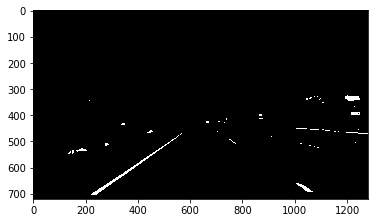

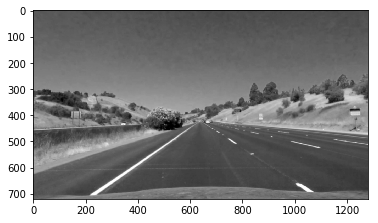

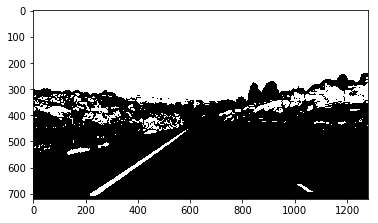

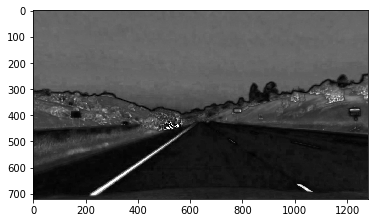

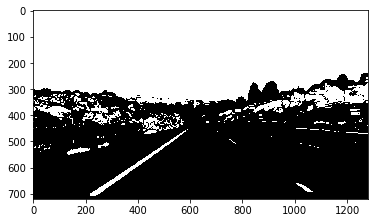

In [12]:
r_channel = blurred[:,:,0]
g_channel = blurred[:,:,1]
b_channel = blurred[:,:,2]

red_thresh = (200, 255)
r_thresholded = red_channel_thresh(r_channel, red_thresh)

plt.figure()
plt.imshow(r_thresholded, cmap='gray')
plt.figure()
plt.imshow(r_channel, cmap='gray')
# plt.figure()
# plt.imshow(g_channel, cmap='gray')
# plt.figure()
# plt.imshow(b_channel, cmap='gray')

hls = convert_hls(blurred)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]

saturation_thresh = (80, 255)
s_thresholded = saturation_channel_thresh(s_channel, saturation_thresh)

plt.figure()
plt.imshow(s_thresholded, cmap='gray')
# plt.figure()
# plt.imshow(h_channel, cmap='gray')
# plt.figure()
# plt.imshow(l_channel, cmap='gray')
plt.figure()
plt.imshow(s_channel, cmap='gray')

color_combined = np.zeros_like(s_thresholded)
color_combined[(r_thresholded == 1) | (s_thresholded==1)] = 1

plt.figure()
plt.imshow(color_combined, cmap='gray')

def color_threshold(img):
    # Aggregate function to put several color threshold functions together. Note parameters are defined outside
    r_channel = img[:,:,0]
    r_thresholded = red_channel_thresh(r_channel, red_thresh)
    s_channel = convert_hls(img)[:,:,2]
    s_thresholded = saturation_channel_thresh(s_channel, saturation_thresh)
    color_combined = np.zeros_like(s_thresholded)
    color_combined[(r_thresholded == 1) | (s_thresholded==1)] = 1
    return color_combined

## Perspective transform

Bird eye view on lanes

In [ ]:
# Mask is not necessary as we are doing persective transform here
